In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors 
import pandas as pd 
import seaborn as sns
import random

## <font color=darkred> Dataset </font>

We provide below two datasets (one to train each model and another one to test each model).

Datasets contain input features (meteorological data) and output (kWh consumptions) to be predicted from the inputs.

In [3]:
df_train = pd.read_csv('data_train.csv')
df_train.head()

,temperature,humidity,horizontal_radiation,normal_radiation,heating,cooling,ventilation,gains
0,4.93,65.34,0.0,0.0,171.65,0.0,0,138.6
1,5.07,54.61,0.0,0.0,170.59,0.0,0,138.6
2,3.71,62.33,0.0,0.0,206.19,0.0,0,138.6
3,2.36,70.05,0.0,0.0,241.49,0.0,0,138.6
4,1.00,77.77,0.0,0.0,275.97,0.0,0,138.6


In [4]:
df_train.shape

(17520, 8)

In [5]:
df_test =pd.read_csv('data_test.csv')
df_test.head()

,temperature,humidity,horizontal_radiation,normal_radiation,heating,cooling,ventilation,gains
0,7.09,88.42,0.0,0.0,0.00,0.0,0,138.6
1,4.00,88.58,0.0,0.0,7.18,0.0,0,138.6
2,2.23,87.25,0.0,0.0,125.72,0.0,0,138.6
3,2.52,87.17,0.0,0.0,106.85,0.0,0,138.6
4,2.72,89.17,0.0,0.0,104.25,0.0,0,138.6


In [6]:
df_test.shape

(8760, 8)

#### Build input/output from dataframe

In [7]:
labels_output = ['heating','cooling','gains','ventilation']
labels_input = ['temperature','humidity','normal_radiation','horizontal_radiation']

In [8]:
def get_input_output(df,labels_usage,labels_input):
    dfX = df[labels_input]
    dfY = df[labels_usage]
    return dfX, dfY

In [9]:
dfX_train, dfY_train = get_input_output(df_train,labels_output,labels_input)
dfX_test, dfY_test = get_input_output(df_test,labels_output,labels_input)

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
def scaler_fit_transform(d_train,d_test):
    scaler = MinMaxScaler()
    data_train_sc = scaler.fit_transform(d_train) 
    data_test_sc = scaler.transform(d_test)
    return scaler, data_train_sc, data_test_sc

In [12]:
scaler_x, X_train_sc, X_test_sc = scaler_fit_transform(dfX_train,dfX_test) 
scaler_y, y_train_sc, y_test_sc = scaler_fit_transform(dfY_train,dfY_test) 

In [206]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index:index+self.seq_len])

In [207]:
# We define a problem where we want to predict 1 week (7*24h) of output from the input
seq_len = 24*7
# Each gradient step uses batch_size sequences of input/output
batch_size = 16

In [208]:
def set_loader(X_train,y_train,X_test,y_test,seq_len,batch_size): 
    train_dataset = TSDataset(torch.Tensor(X_train), torch.Tensor(y_train), seq_len)
    test_dataset = TSDataset(torch.Tensor(X_test), torch.Tensor(y_test), seq_len)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, drop_last=True)
    return train_dataset, test_dataset, train_loader, test_loader

In [209]:
train_dataset, test_dataset, train_loader, test_loader = set_loader(X_train_sc,y_train_sc,X_test_sc,y_test_sc,seq_len,batch_size)

In [210]:
import torch
import torch.nn as nn
import torch.optim as optim

In [211]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## <font color=darkred> Models </font>

### Recurrent architectures 

 - Complete the following RNNmodel class

In [221]:
class RNNmodel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
        """
        input_d (int): dimension of the input layer
        hidden_d (int): dimension of each layer
        layer_n (int): number of layers
        output_d (int): dimension of output layer
        dropout_p (float): probability of dropping neurons
        """
        super(RNNmodel, self).__init__()

        self.hidden_d = hidden_d
        self.layer_n = layer_n
        
        # complete the following RNN module
        # TO DO
        self.rnn = torch.nn.RNN(input_d, hidden_d, layer_n, dropout=dropout_p, nonlinearity='relu')
        # Add a linear output for the regression problem
        # TO DO
        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        """
        x (torch.Tensor): input tensor (batch size, sequence length, input_d)
        """

        # Forward pass
        # call the RNN module to compute the output and the hidden state of the RNN fed with x
        # TO DO
        h0 = torch.randn(self.layer_n, x.size(1), self.hidden_d).to(x.device)
        out,_ = self.rnn(x, h0)
        out = self.fc(out)
        return out

 - Complete similarly the following LSTMmodel class

In [222]:
class LSTMmodel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
        """
        input_d (int): dimension of the input layer
        hidden_d (int): dimension of each layer
        layer_n (int): number of layers
        output_d (int): dimension of output layer
        dropout_p (float): probability of dropping neurons
        """
        super(LSTMmodel, self).__init__()

        self.hidden_d = hidden_d
        self.layer_d = layer_n

        # complete the LSTM module
        # TO DO 
        self.lstm = nn.LSTM(input_d, hidden_d, layer_n, dropout=dropout_p, nonlinearity='relu', batch_first=True)
        self.fc = nn.Linear(hidden_d, output_d)
        

    def forward(self, x):
        """
        x (torch.Tensor): input tensor (batch size, sequence length, input_d)
        """

        # Complete the forward pass 
        # TO DO
        h0 = torch.zeros(x.input_d, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(x.input_d, x.size(0), self.hidden_size).to(x.device)

        # LSTM output
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        
        return out

 - Provide similarly a GRUmodel class

In [223]:
# TO DO
class GRUmodel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
        """
        input_d (int): dimension of the input layer
        hidden_d (int): dimension of each layer
        layer_n (int): number of layers
        output_d (int): dimension of output layer
        dropout_p (float): probability of dropping neurons
        """
        super(GRUmodel, self).__init__()

        self.hidden_d = hidden_d
        self.layer_d = layer_n

        # complete the gru module
        # TO DO 
        self.gru = nn.GRU(input_d, hidden_d, layer_n, dropout=dropout_p, nonlinearity='relu', batch_first=True)
        self.fc = nn.Linear(hidden_d, output_d)
        

    def forward(self, x):
        """
        x (torch.Tensor): input tensor (batch size, sequence length, input_d)
        """

        # Complete the forward pass 
        # TO DO
        h0 = torch.zeros(x.input_d, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(x.input_d, x.size(0), self.hidden_size).to(x.device)

        # gru output
        out, _ = self.gru(x, (h0, c0))
        out = self.fc(out)
        
        return out

## <font color=darkred> Optimization </font>

 - Complete the following class to optimize all models

In [254]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, device):
        """
        model: selected model 
        loss_fn: loss function
        optimizer: function to optimize loss
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """
        x: input data
        y: target data
        """

        self.model.train()

        # Compute the prediction provided by model 
        # TO DO
        yhat = self.model(x)

        # Compute loss
        # TO DO
        loss = self.loss_fn(yhat, y)
        
        # Gradient for the optimization
        loss.backward()

        # Updates parameters
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """
        train_loader: training data
        val_loader: validation data
        batch_size: batch size
        n_epochs: number of epochs
        n_features: number of features
        """
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Compute the loss using train_step on the current batch
                # TO DO
                loss = self.train_step(x_batch,y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(self.device)
                    y_val = y_val.to(self.device)
                    
                    self.model.eval()
                    # Compute the loss function on the current validation batch
                    # TO DO
                    yhat = self.model(x_val)
                    yhat = yhat.cpu().data.numpy()
                    y_val = y_val.cpu().data.numpy() 
                    yhat = torch.Tensor(yhat)
                    y_val = torch.Tensor(y_val)
                    val_loss = self.loss_fn(yhat, y_val)
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)


                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        test_loader: dataLoader
        batch_size: batch size
        n_features: number of features
        """
    
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(self.device)
                y_test = y_test.to(self.device)

                self.model.eval()
                yhat = self.model(x_test)

                yhat=yhat.cpu().data.numpy()
                predictions.append(yhat)
                y_test=y_test.cpu().data.numpy()
                values.append(y_test)

        return predictions, values

    def plot_losses(self):
        # Plot train_losses and val_losses (to be called after training)
        # TO DO
        plt.plot(range(len(self.train_losses)) , self.train_losses)
        plt.title('Trainig loss')
        plt.show()


## <font color=darkred> Training </font>

In [255]:
# parameters of the neural networks
# input dimension
input_d = 4
# output dimension
output_d = 4
# hidden layers dimension
hidden_d = 8
#number of layers
layer_n = 2
# number of times all data are processed during training
n_epochs = 10
# parameters for the optimizer
lrate = 1e-4
weight_decay = 1e-6 

In [256]:
dropout_p = 0.2
model_params = {'input_d': input_d,
                'hidden_d' : hidden_d,
                'layer_n' : layer_n,
                'output_d' : output_d,
                'dropout_p': dropout_p}

In [257]:
def get_model(model, model_params):
    models = {"rnn": RNNmodel,"lstm": LSTMmodel,"gru": GRUmodel}
    return models.get(model.lower())(**model_params)

In [258]:
# default loss function: MSE
loss_fn = nn.MSELoss(reduction="mean")
device = "cuda" if torch.cuda.is_available() else "cpu"

 - Complete the following cell to train a RNN

[1/50] Training loss: 0.0919	 Validation loss: 0.0593
[2/50] Training loss: 0.0632	 Validation loss: 0.0570
[3/50] Training loss: 0.0608	 Validation loss: 0.0562
[4/50] Training loss: 0.0598	 Validation loss: 0.0556
[5/50] Training loss: 0.0592	 Validation loss: 0.0554
[6/50] Training loss: 0.0589	 Validation loss: 0.0551
[7/50] Training loss: 0.0586	 Validation loss: 0.0550
[8/50] Training loss: 0.0584	 Validation loss: 0.0549
[9/50] Training loss: 0.0582	 Validation loss: 0.0548
[10/50] Training loss: 0.0579	 Validation loss: 0.0547
[11/50] Training loss: 0.0576	 Validation loss: 0.0547
[12/50] Training loss: 0.0572	 Validation loss: 0.0547
[13/50] Training loss: 0.0568	 Validation loss: 0.0548
[14/50] Training loss: 0.0564	 Validation loss: 0.0550
[15/50] Training loss: 0.0561	 Validation loss: 0.0550
[16/50] Training loss: 0.0558	 Validation loss: 0.0551
[17/50] Training loss: 0.0555	 Validation loss: 0.0551
[18/50] Training loss: 0.0552	 Validation loss: 0.0552
[19/50] Training lo

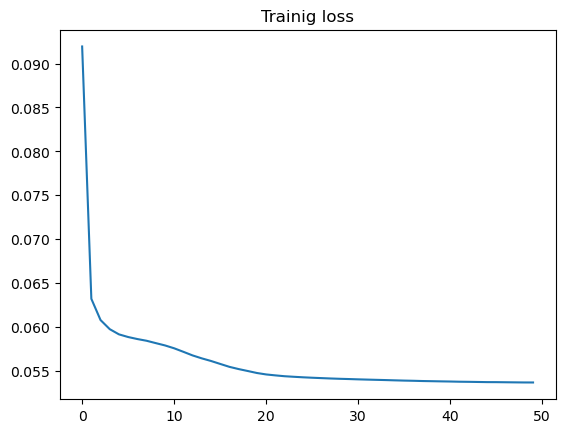

In [259]:
model_name = 'rnn'
# get model 
# TO DO
model = get_model(model_name,model_params)
model = model.to(device)
# Set optimizer
optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=weight_decay)
# Call the optimization class, train opt_rnn and plot losses
# TO DO 
opt_rnn = Optimization(model,loss_fn,optimizer,device=device)
opt_rnn.train(train_loader,test_loader,batch_size=batch_size)
opt_rnn.plot_losses()

 - Analyze the influence of the learning rate of the optimizer and of the batch size on the test and train losses

In [ ]:
# TO DO

 - Train a LSTM and a GRU model

In [ ]:
# TO DO

- Compute the MSE for each model on the test set  and display some predictions to provide qualitative results

In [ ]:
# TO DO

 - Perform a cross validation to get the results of the best model (you can optimize the number of layers and the hidden dimension for instance).

 - CNN can also be used to model time series, in particular with one dimensional convolutional layers.
 
 - These layers are defined by ``nn.Conv1d`` in Torch with main arguments ``in_channels``, ``out_channels``, ``kernel_size`` (an integer in the one dimensional setting), ``stride`` and ``padding``.
 
 - Build a CNNmodel class and compare its performance with previous recurrent models.

In [ ]:
# TO DO

 - (**Bonus**) Implement a (conditional) VAE to train the distribution of the ouput

In [ ]:
#TO DO